In [1]:
! pip install --upgrade openai
! pip install --upgrade azure.identity
! pip install --upgrade pillow

In [2]:
from openai import AzureOpenAI
import json
import dotenv  
import time  
from openai import AzureOpenAI  
from openai.types.beta.assistant_stream_event import (  
    ThreadRunStepCreated,  
    ThreadRunStepDelta,  
    ThreadRunStepCompleted,  
    ThreadRunCancelled,  
    ThreadMessageCreated,  
    ThreadMessageDelta  
)  
from openai.types.beta.threads.text_delta_block import TextDeltaBlock  
from openai.types.beta.threads.runs.tool_calls_step_details import ToolCallsStepDetails  
from openai.types.beta.threads.runs.code_interpreter_tool_call import (  
    CodeInterpreterOutputImage,  
    CodeInterpreterOutputLogs  
)  
import base64  
import os
os.environ["AZURE_OPENAI_API_KEY"] = ""
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://<>.openai.azure.com/"
os.environ["OPENAI_GPT_DEPLOYMENT"] = "gpt-4"
api_version="2024-05-01-preview"
os.environ["AZURE_OPENAI_API_VERSION"] = api_version

client = AzureOpenAI(
    api_key=os.getenv('AZURE_OPENAI_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
    api_version=os.getenv('AZURE_OPENAI_API_VERSION')
)


In [3]:
# Don't reupload the file if it already exists

file = client.files.create(
    file=open("Emissions.xlsx", "rb"),
    purpose="assistants"
)
print(file.id)
time.sleep(20)

assistant-xkw5gyvPk0sla3XCnvBFJR4E


In [4]:
import time

list_assistants = client.beta.assistants.list()
assistant_ID = None
for assistant in list_assistants:
    if assistant.name == "SustainabilityInsights":
        assistant_ID = assistant.id

if assistant_ID is None:
    print("Creating new assistant")
    client.beta.assistants.create(
        name="SustainabilityInsights",
        temperature=0,
        instructions="""You are sustainability copilot and you are supposed to answer user's queries using the data present in Emissions.xlsx (database).
        Generate graphs wherever possible to give more insights about the user's emissions. Try to give detailed and formatted report about the emission for the user's question. 
        """,
        tools=[{"type": "code_interpreter"}],
        model="gpt-4",
        tool_resources={
        "code_interpreter": {
                "file_ids": [file.id]
            }
        }
    )
    
    assistant_ID = assistant.id
    time.sleep(10)


In [5]:
assistant = client.beta.assistants.retrieve(assistant_id=assistant_ID)

When you run the thread, you can provide extra instructions via the `instructions` parameter.

In [6]:
import os  
import time  
import json  
from PIL import Image  
from IPython.display import display, Markdown  
  
def generate_answer_agent_CI(message, client, assistant, thread=None):  
    if thread is None:  
        thread = client.beta.threads.create()  
      
    # Create a new message in the thread  
    client.beta.threads.messages.create(  
        thread_id=thread.id,  
        role="user",  
        content=message  
    )  
      
    # Create a run with streaming enabled  
    stream = client.beta.threads.runs.create(  
        thread_id=thread.id,  
        assistant_id=assistant.id,  
        stream=True  
    )  
      
    # Initialize lists to store assistant outputs and code inputs  
    assistant_output = []  
    code_generated = ""  
    images_generated = []
      
    # Create directory for storing images if it doesn't exist  
    image_folder = "generated_images"  
    if not os.path.exists(image_folder):  
        os.makedirs(image_folder)  
  
    # Simulated event stream loop to process events  
    for event in stream:  
        # If the event is a tool call step creation  
        if isinstance(event, ThreadRunStepCreated):  
            if event.data.step_details.type == "tool_calls":  
                assistant_output.append({"type": "code_input", "content": ""})  
  
        # If the event is a delta in tool call step (new input from code interpreter)  
        elif isinstance(event, ThreadRunStepDelta):  
            if event.data.delta.step_details.tool_calls[0].code_interpreter is not None:  
                code_interpreter = event.data.delta.step_details.tool_calls[0].code_interpreter  
                code_input_delta = code_interpreter.input  
                if code_input_delta:  
                    code_generated += code_input_delta  
  
        # If the event indicates the completion of a tool call step  
        elif isinstance(event, ThreadRunStepCompleted):  
            assistant_output.append({"type": "code", "content": code_generated})
            code_generated = ""
            if isinstance(event.data.step_details, ToolCallsStepDetails):  
                code_interpreter = event.data.step_details.tool_calls[0].code_interpreter  
                # Process any outputs from the code interpreter  
                if code_interpreter.outputs:  
                    for code_interpreter_output in code_interpreter.outputs:  
                        # If the output is an image  
                        if isinstance(code_interpreter_output, CodeInterpreterOutputImage):  
                            image_file_id = code_interpreter_output.image.file_id  
                            image_data = client.files.content(image_file_id)  
                            image_data_bytes = image_data.read()  
                            image_path = os.path.join(image_folder, f"{image_file_id}.png")  
                            # Save the image locally  
                            with open(image_path, "wb") as file:  
                                file.write(image_data_bytes)  
                            # Display the image in the Jupyter Notebook  
                            img = Image.open(image_path)  
                            # display(img)  
                            assistant_output.append({"type": "image", "content": image_path})  
                        # If the output is a console log  
                        elif isinstance(code_interpreter_output, CodeInterpreterOutputLogs):  
                            code_output = code_interpreter_output.logs  
                            assistant_output.append({"type": "code_output", "content": code_output})  
  
        # If a new message is created in the thread  
        elif isinstance(event, ThreadMessageCreated):  
            assistant_output.append({"type": "text", "content": ""})  
  
        # If there's a delta in message content  
        elif isinstance(event, ThreadMessageDelta):  
            if isinstance(event.data.delta.content[0], TextDeltaBlock):  
                assistant_output[-1]["content"] += event.data.delta.content[0].text.value  
  
    return {  
        "assistant_outputs": assistant_output
    }  
  


**Assistant's Message:**

Let's first load the data from the uploaded file and inspect its contents to understand the structure and identify the relevant columns for analysis.

**Code:**

```python
import pandas as pd

# Load the data from the uploaded file
file_path = '/mnt/data/assistant-eZeAWiimfvn03YaWP31tK9XZ'
emissions_data = pd.read_excel(file_path)

# Display the first few rows of the dataframe to understand its structure
emissions_data.head()
```

**Assistant's Message:**

The dataset contains several columns, including `dateKey`, `azureRegionDisplayName`, and various carbon emission metrics such as `scope1CarbonEmission`, `scope2MarketCarbonEmission`, `scope2LocationCarbonEmission`, and `scope3CarbonEmission`.

To determine the regions with the highest carbon emissions over the last 3 years, we will:
1. Filter the data for the last 3 years.
2. Aggregate the carbon emissions by region.
3. Identify the regions with the highest total carbon emissions.

Let's proceed with this analysis.

**Code:**

```python
# Convert the dateKey to datetime format and filter data for the last 3 years
emissions_data['dateKey'] = pd.to_datetime(emissions_data['dateKey'], format='%Y%m%d')
last_3_years_data = emissions_data[emissions_data['dateKey'] >= pd.Timestamp.now() - pd.DateOffset(years=3)]

# Calculate total carbon emissions by region
last_3_years_data['totalCarbonEmission'] = (
    last_3_years_data['scope1CarbonEmission'] +
    last_3_years_data['scope2MarketCarbonEmission'] +
    last_3_years_data['scope2LocationCarbonEmission'] +
    last_3_years_data['scope3CarbonEmission']
)

# Aggregate total carbon emissions by region
region_emissions = last_3_years_data.groupby('azureRegionDisplayName')['totalCarbonEmission'].sum().reset_index()

# Identify the regions with the highest total carbon emissions
top_regions = region_emissions.sort_values(by='totalCarbonEmission', ascending=False).head(10)

top_regions
```

**Assistant's Message:**

The regions with the highest carbon emissions over the last 3 years are as follows:

1. **East US 2**: 2.359504 metric tons
2. **Brazil South**: 2.161731 metric tons
3. **North Central US**: 2.161098 metric tons
4. **West US 3**: 1.757913 metric tons
5. **East US**: 1.599273 metric tons
6. **West US**: 1.122582 metric tons
7. **South Central US**: 1.099851 metric tons
8. **West Europe**: 1.023429 metric tons
9. **Japan East**: 0.789152 metric tons
10. **Australia East**: 0.510216 metric tons

Let's visualize this data with a bar chart to provide more insights.

**Code:**

```python
import matplotlib.pyplot as plt

# Plot the top regions with the highest carbon emissions
plt.figure(figsize=(12, 6))
plt.barh(top_regions['azureRegionDisplayName'], top_regions['totalCarbonEmission'], color='skyblue')
plt.xlabel('Total Carbon Emissions (metric tons)')
plt.ylabel('Azure Region')
plt.title('Top 10 Azure Regions with Highest Carbon Emissions (Last 3 Years)')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest emissions at the top
plt.show()
```

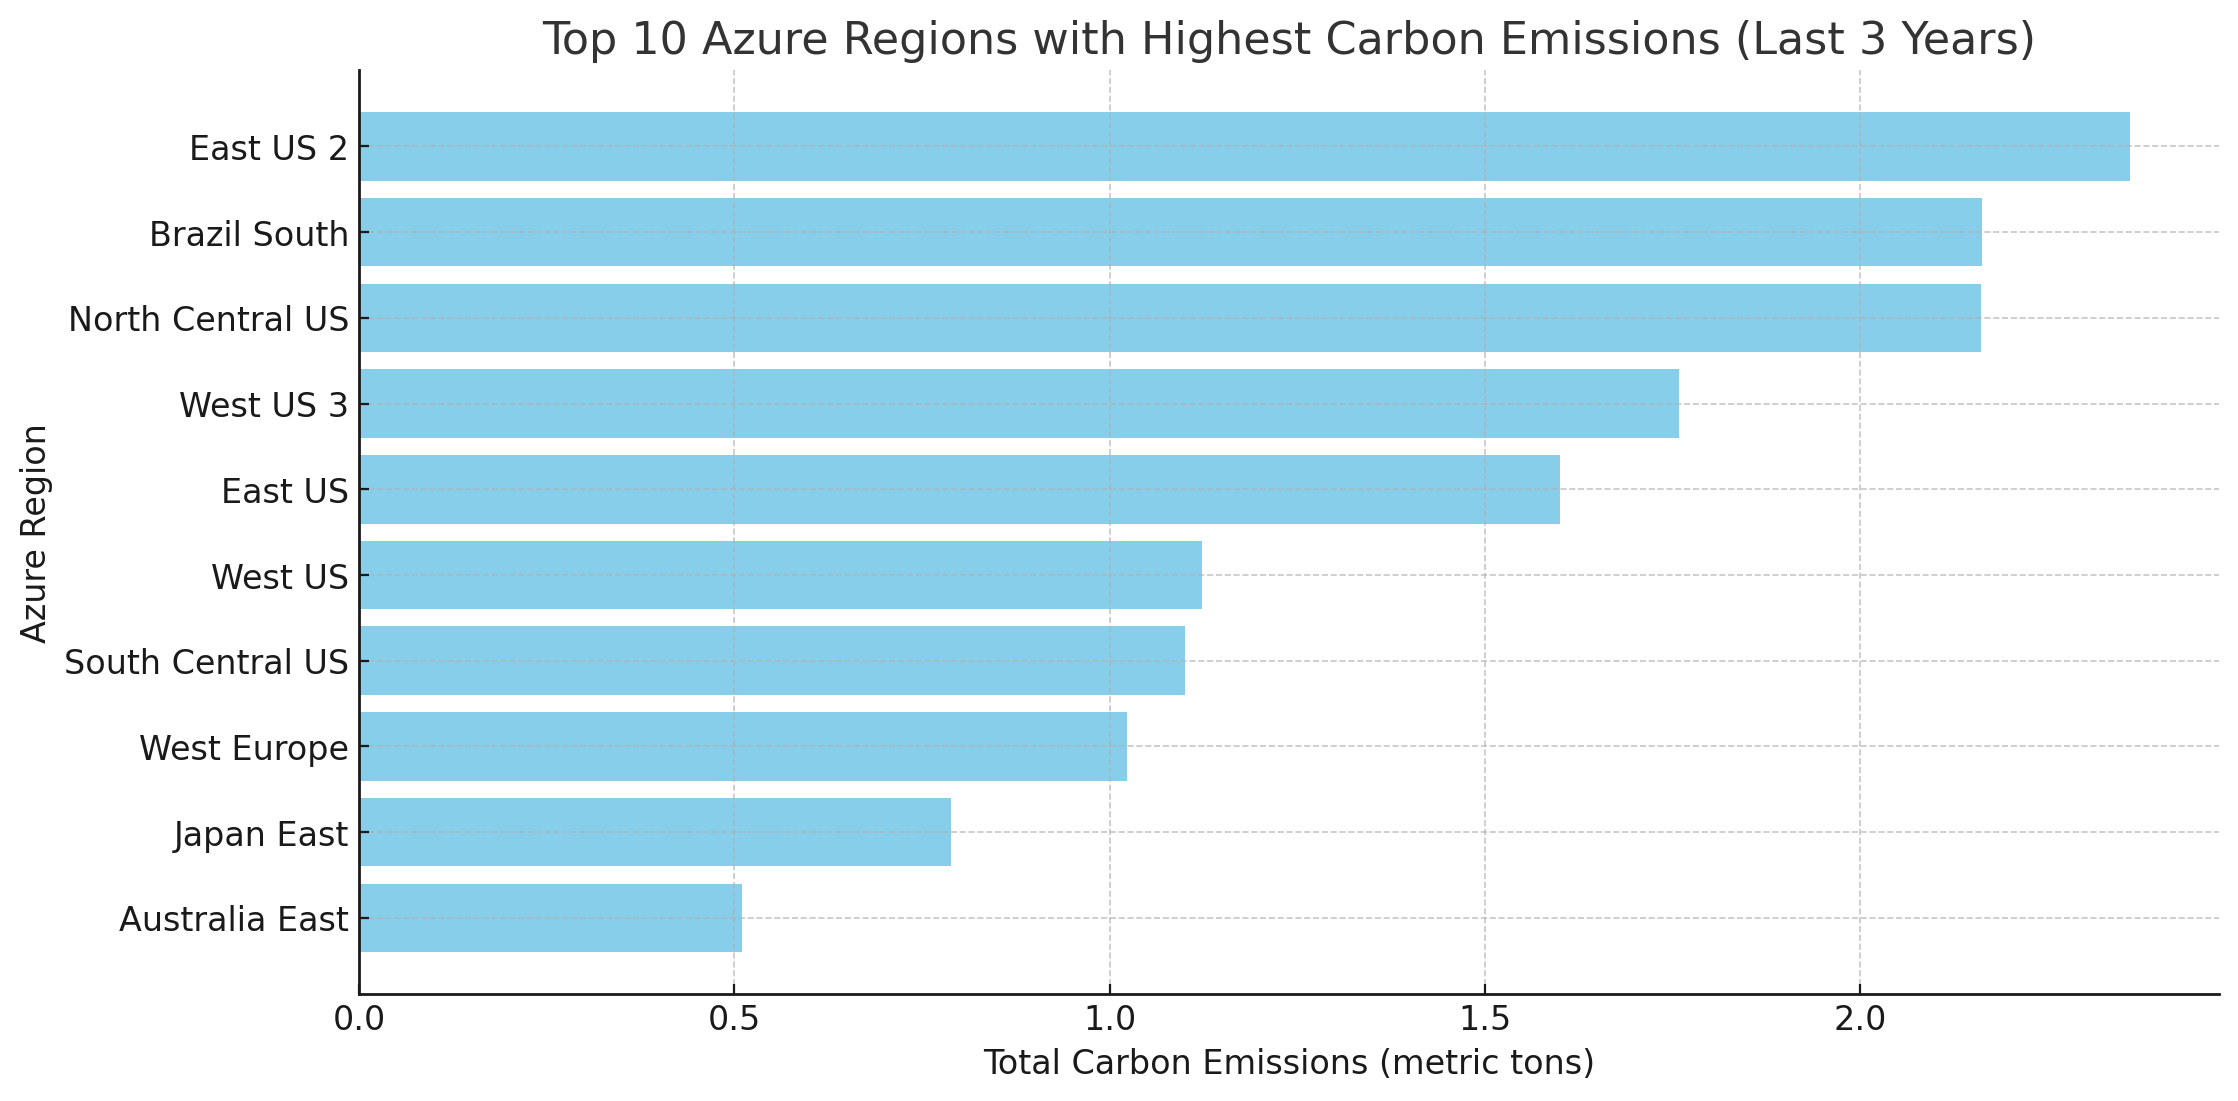

**Assistant's Message:**

The bar chart above illustrates the top 10 Azure regions with the highest carbon emissions over the last 3 years. The regions "East US 2", "Brazil South", and "North Central US" are the top three contributors to carbon emissions.

If you have any further questions or need additional analysis, please let me know!

In [7]:
prompt = "Give me the regions is having the highest carbon emissions over the last 3 years?"

thread = generate_answer_agent_CI(message=prompt, client=client,assistant=assistant,thread=None)
for output in thread["assistant_outputs"]:
    if output["type"] == "text":
        if output["content"].strip():
            display(Markdown(f"**Assistant's Message:**\n\n{output['content']}"))
    elif output["type"] == "code":
        if output["content"].strip():
            display(Markdown(f"**Code:**\n\n```python\n{output['content']}\n```"))
    elif output["type"] == "code_output":
        if output["content"].strip():
            display(Markdown(f"**Code Output:**\n\n```\n{output['content']}\n```"))
    elif output["type"] == "image":
        img = Image.open(output["content"])
        display(img)
        


In [8]:
prompt = "Can you give me the total usage of Azure storage in US for Qtr 2 2023?"
thread = generate_answer_agent_CI(message=prompt, client=client,assistant=assistant, thread=None)
for output in thread["assistant_outputs"]:
    if output["type"] == "text":
        if output["content"].strip():
            display(Markdown(f"**Assistant's Message:**\n\n{output['content']}"))
    elif output["type"] == "code":
        if output["content"].strip():
            display(Markdown(f"**Code:**\n\n```python\n{output['content']}\n```"))
    elif output["type"] == "code_output":
        if output["content"].strip():
            display(Markdown(f"**Code Output:**\n\n```\n{output['content']}\n```"))
    elif output["type"] == "image":
        img = Image.open(output["content"])
        display(img)
        

        
        

**Code:**

```python
import pandas as pd

# Load the Excel file
file_path = '/mnt/data/assistant-eZeAWiimfvn03YaWP31tK9XZ'
xls = pd.ExcelFile(file_path)

# Check sheet names to understand the structure of the file
sheet_names = xls.sheet_names
sheet_names
```

**Code:**

```python
# Load the data from the first sheet
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Display the first few rows of the dataframe to understand its structure
df.head()
```

**Code:**

```python
# Filter the data for Azure storage in the US for Q2 2023
# Q2 includes April, May, and June (202304, 202305, 202306)
# US regions include 'Central US', 'East US', 'East US 2', 'North Central US', 'South Central US', 'West US', 'West US 2'

us_regions = ['Central US', 'East US', 'East US 2', 'North Central US', 'South Central US', 'West US', 'West US 2']
q2_2023_months = [202304, 202305, 202306]

# Filter the dataframe
filtered_df = df[(df['azureRegionDisplayName'].isin(us_regions)) & 
                 (df['meteredService'] == 'Storage') & 
                 (df['dateKey'].astype(str).str[:6].astype(int).isin(q2_2023_months))]

# Calculate the total usage
total_usage = filtered_df['totalUsage'].sum()
total_usage
```

**Assistant's Message:**

The total usage of Azure storage in the US for Q2 2023 is approximately **518.44 units**.

Here is a detailed breakdown of the data:

- **Regions considered**: Central US, East US, East US 2, North Central US, South Central US, West US, West US 2
- **Months considered**: April 2023, May 2023, June 2023
- **Service considered**: Storage

If you need any further analysis or details, please let me know!

**Assistant's Message:**

Let's start by loading the data from the uploaded file and then analyze the Year-over-Year (YoY) increase or decrease in Scope 3 emissions from compute services for Europe.

**Code:**

```python
import pandas as pd

# Load the data from the uploaded file
file_path = '/mnt/data/assistant-eZeAWiimfvn03YaWP31tK9XZ'
emissions_data = pd.read_excel(file_path)

# Display the first few rows of the dataframe to understand its structure
emissions_data.head()
```

**Assistant's Message:**

The dataset contains various columns, including `dateKey`, `azureRegionDisplayName`, and `scope3CarbonEmission`. To analyze the Year-over-Year (YoY) increase or decrease in Scope 3 emissions from compute services for Europe, we need to filter the data for the relevant region and service category, and then calculate the YoY change.

Let's proceed with the following steps:
1. Filter the data for Europe region and compute services.
2. Aggregate the Scope 3 emissions by year.
3. Calculate the YoY change in emissions.

Let's start with step 1.

**Code:**

```python
# Convert dateKey to datetime format
emissions_data['dateKey'] = pd.to_datetime(emissions_data['dateKey'], format='%Y%m%d')

# Filter data for Europe region and compute services
europe_compute_data = emissions_data[
    (emissions_data['azureRegionDisplayName'].str.contains('Europe', case=False)) &
    (emissions_data['meteredService'].str.contains('Compute', case=False))
]

# Display the filtered data
europe_compute_data.head()
```

**Assistant's Message:**

We have successfully filtered the data for Europe region and compute services. Now, let's proceed to aggregate the Scope 3 emissions by year and calculate the Year-over-Year (YoY) change.

We'll follow these steps:
1. Extract the year from the `dateKey` column.
2. Group the data by year and sum the Scope 3 emissions.
3. Calculate the YoY change in emissions.

Let's perform these steps.

**Code:**

```python
# Extract the year from the dateKey column
europe_compute_data['year'] = europe_compute_data['dateKey'].dt.year

# Group the data by year and sum the Scope 3 emissions
annual_emissions = europe_compute_data.groupby('year')['scope3CarbonEmission'].sum().reset_index()

# Calculate the YoY change in emissions
annual_emissions['YoY_change'] = annual_emissions['scope3CarbonEmission'].pct_change() * 100

# Display the annual emissions with YoY change
annual_emissions
```

**Code Output:**

```
/tmp/ipykernel_14/2679747267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  europe_compute_data['year'] = europe_compute_data['dateKey'].dt.year

```

**Assistant's Message:**

Here is the Year-over-Year (YoY) change in Scope 3 emissions from compute services for Europe:

| Year | Scope 3 Carbon Emission (in metric tons) | YoY Change (%) |
|------|------------------------------------------|----------------|
| 2022 | 0.026730                                 | -              |
| 2023 | 0.033316                                 | +24.64%        |
| 2024 | 0.007304                                 | -78.08%        |

- From 2022 to 2023, there was an increase of approximately 24.64% in Scope 3 emissions.
- From 2023 to 2024, there was a significant decrease of approximately 78.08% in Scope 3 emissions.

Let's visualize this data with a graph to provide more insights.

**Code:**

```python
import matplotlib.pyplot as plt

# Plot the Scope 3 emissions and YoY change
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Scope 3 emissions
ax1.bar(annual_emissions['year'], annual_emissions['scope3CarbonEmission'], color='b', alpha=0.6, label='Scope 3 Emissions')
ax1.set_xlabel('Year')
ax1.set_ylabel('Scope 3 Carbon Emission (in metric tons)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot YoY change
ax2 = ax1.twinx()
ax2.plot(annual_emissions['year'], annual_emissions['YoY_change'], color='r', marker='o', label='YoY Change')
ax2.set_ylabel('YoY Change (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend
plt.title('Year-over-Year (YoY) Change in Scope 3 Emissions from Compute Services for Europe')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()
```

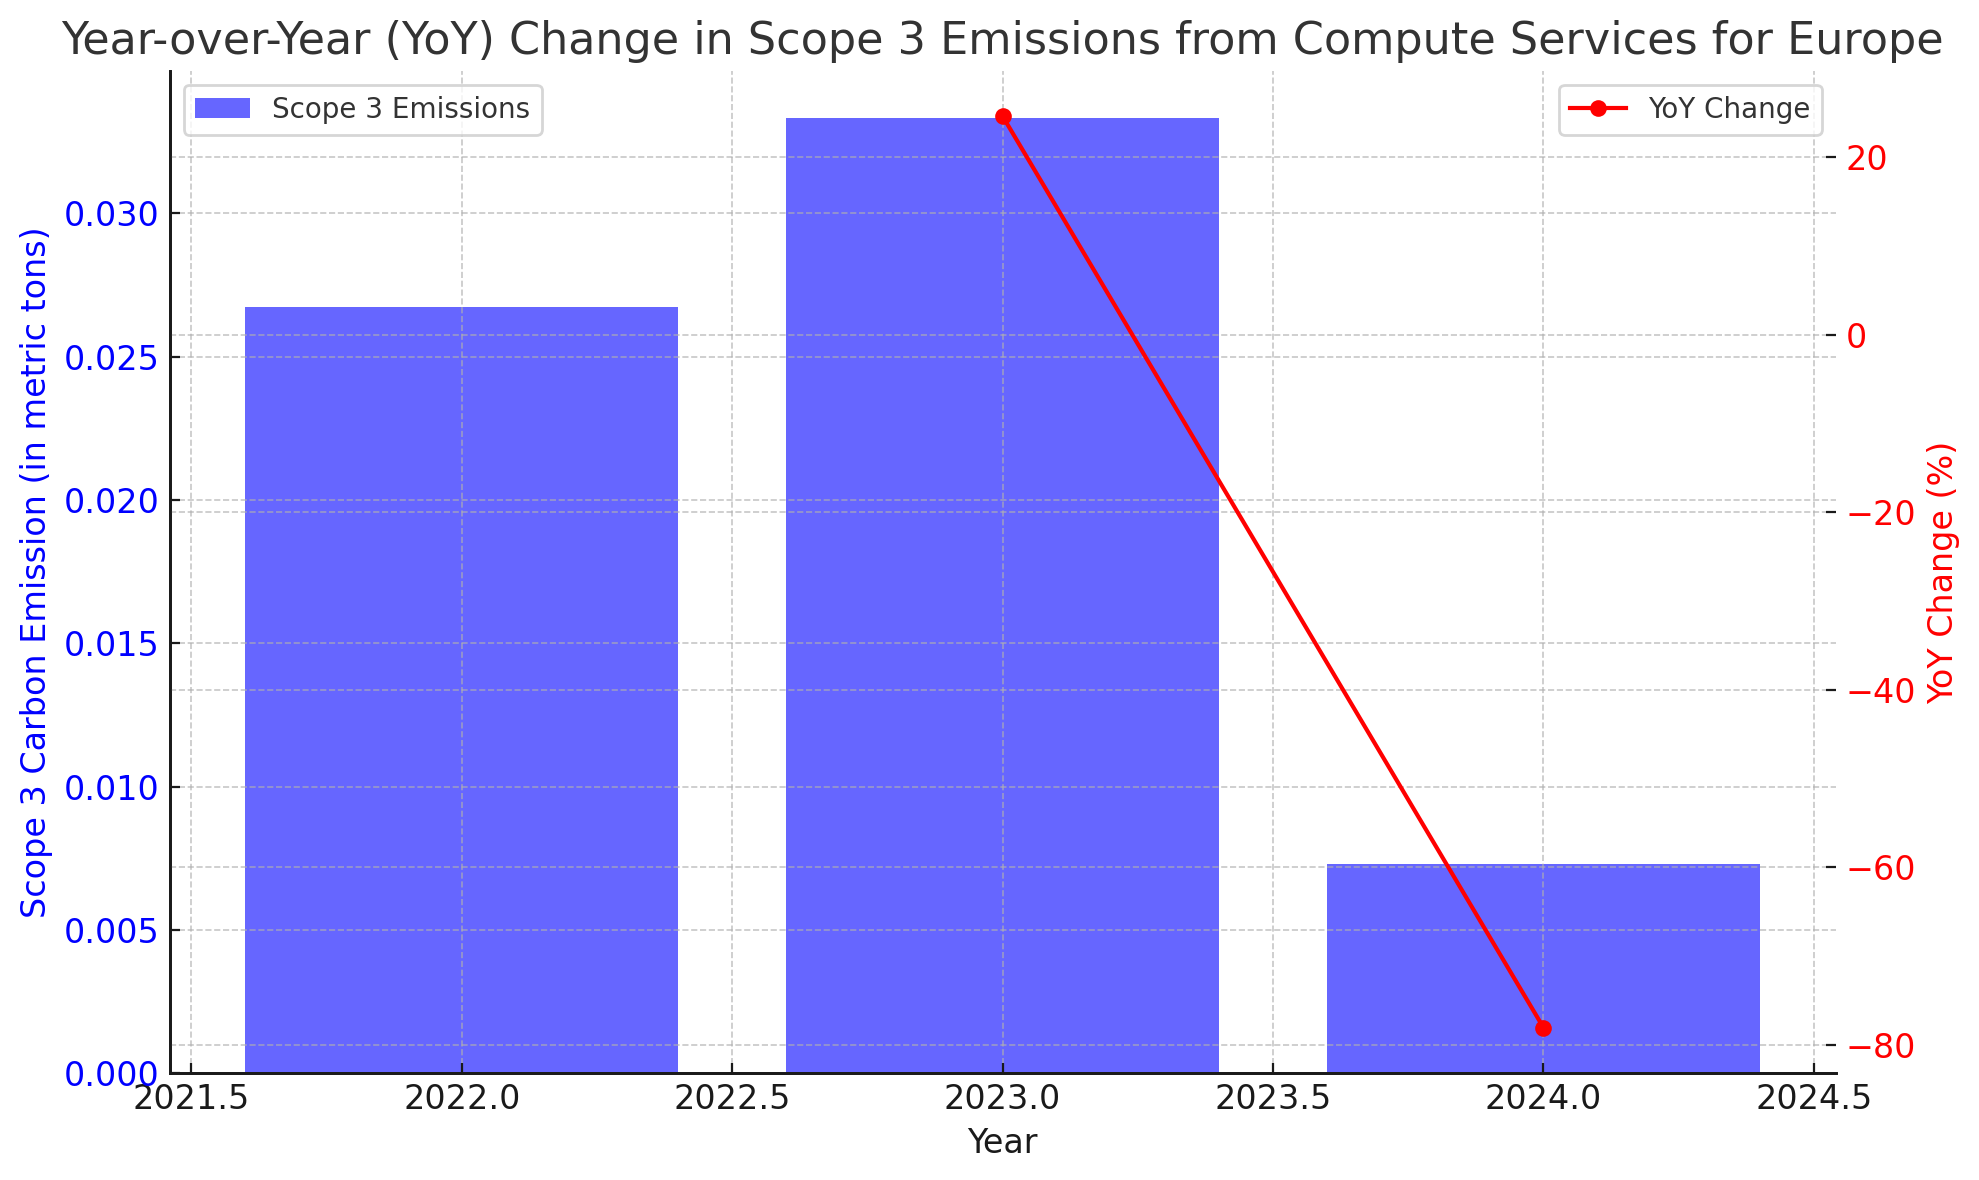

**Assistant's Message:**

The graph above illustrates the Year-over-Year (YoY) change in Scope 3 emissions from compute services for Europe:

- The blue bars represent the total Scope 3 carbon emissions for each year.
- The red line with markers represents the YoY percentage change in emissions.

From the graph, we can observe the following:
- There was an increase in Scope 3 emissions from 2022 to 2023.
- There was a significant decrease in Scope 3 emissions from 2023 to 2024.

This visualization provides a clear understanding of the trends in Scope 3 emissions over the years. If you have any further questions or need additional analysis, please let me know!

In [9]:
prompt = "What is the YoY increase/decrease in Scope 3 emissions from compute Service for Europe"
thread = generate_answer_agent_CI(message=prompt, client=client, assistant=assistant, thread=None)
for output in thread["assistant_outputs"]:
    if output["type"] == "text":
        if output["content"].strip():
            display(Markdown(f"**Assistant's Message:**\n\n{output['content']}"))
    elif output["type"] == "code":
        if output["content"].strip():
            display(Markdown(f"**Code:**\n\n```python\n{output['content']}\n```"))
    elif output["type"] == "code_output":
        if output["content"].strip():
            display(Markdown(f"**Code Output:**\n\n```\n{output['content']}\n```"))
    elif output["type"] == "image":
        img = Image.open(output["content"])
        display(img)
        


In [11]:
prompt = "Can you give me the top 5 subscriptions and the services which are contributing to maximum Scope 3 emissions in 2023?"
thread = generate_answer_agent_CI(message=prompt, client=client, assistant=assistant, thread=None)
for output in thread["assistant_outputs"]:
    if output["type"] == "text":
        if output["content"].strip():
            display(Markdown(f"**Assistant's Message:**\n\n{output['content']}"))
    elif output["type"] == "code":
        if output["content"].strip():
            display(Markdown(f"**Code:**\n\n```python\n{output['content']}\n```"))
    elif output["type"] == "code_output":
        if output["content"].strip():
            display(Markdown(f"**Code Output:**\n\n```\n{output['content']}\n```"))
    elif output["type"] == "image":
        img = Image.open(output["content"])
        display(img)
        